### 🚀 Best Model Performance  
This notebook includes my top-performing model on the Public Leaderboard, reaching an RMSE of **2.055**.


In [1]:
# ============================================
# Load bundle + prepare base blocks
# ============================================

import numpy as np
import joblib

# Load the full bundle created earlier
bundle = joblib.load("/mnt/data/full_training_bundle_for_nll.joblib")

# Embeddings (768-d each)
train_resp = bundle["train_resp"]   # (N, 768)
train_user = bundle["train_user"]
train_sys  = bundle["train_sys"]
train_comb = bundle["train_comb"]

test_resp  = bundle["test_resp"]    # (T, 768)
test_user  = bundle["test_user"]
test_sys   = bundle["test_sys"]
test_comb  = bundle["test_comb"]

# DataFrames
train_df   = bundle["train_df"]
test_df    = bundle["test_df"]

# Targets
y_real = bundle["y"].astype(np.float32)     # (N,)

# Metric info
metric_embeddings = bundle["metric_embeddings"].astype(np.float32)  # (145, 768)
metric_to_idx     = bundle["metric_to_idx"]
metric_names      = bundle["metric_names"]

train_metric_idx = bundle["train_metric_idx"].astype(int)     # (N,)
test_metric_idx  = bundle["test_metric_idx"].astype(int)      # (T,)

train_sys_missing = bundle["train_sys_missing_flag"].astype(int)
test_sys_missing  = bundle["test_sys_missing_flag"].astype(int)

print("Loaded shapes:")
print(" train_comb:", train_comb.shape)
print(" test_comb :", test_comb.shape)
print(" metric emb:", metric_embeddings.shape)
print(" y_real    :", y_real.shape)


Loaded shapes:
 train_comb: (5000, 768)
 test_comb : (3638, 768)
 metric emb: (145, 768)
 y_real    : (5000,)


### Build Negative-Augmented Embeddings

In [2]:
# ======================================================
#  Construct augmented training data 
# ======================================================

import numpy as np
import os

AUG_DIR = "/mnt/data/aug_v5"
os.makedirs(AUG_DIR, exist_ok=True)

rng = np.random.default_rng(42)

# ------------------------------------------------------
# Base real blocks (unchanged)
# ------------------------------------------------------
X_real_raw = train_comb.astype(np.float32)             # (N, 768)
y_real     = y_real.astype(np.float32)                 # (N,)
metric_real = train_metric_idx.astype(int)             # (N,)

N = len(X_real_raw)

metric_vec = metric_embeddings[metric_real]            # (N, 768)

# 1536-d real representation = [ text_embedding | metric_embedding ]
X_real_full = np.hstack([X_real_raw, metric_vec]).astype(np.float32)

print("Real block:", X_real_full.shape, y_real.shape)


# ------------------------------------------------------
# NEGATIVE SET 1 — Shuffled text embeddings
# ------------------------------------------------------
perm1 = rng.permutation(N)

X_neg1 = np.hstack([X_real_raw[perm1], metric_vec])
y_neg1 = rng.normal(1.0, 0.4, size=N).clip(0, 2.5).astype(np.float32)


# ------------------------------------------------------
# NEGATIVE SET 2 — Noisy text embeddings
# ------------------------------------------------------
noise = rng.normal(scale=0.60, size=X_real_raw.shape)

X_neg2 = np.hstack([X_real_raw + noise, metric_vec])
y_neg2 = rng.normal(1.3, 0.5, size=N).clip(0, 3.0).astype(np.float32)


# ------------------------------------------------------
# NEGATIVE SET 3 — Metric swap
# ------------------------------------------------------
perm2 = rng.permutation(N)

X_neg3 = np.hstack([X_real_raw, metric_vec[perm2]])
y_neg3 = rng.normal(1.8, 0.6, size=N).clip(0, 4.0).astype(np.float32)


# ------------------------------------------------------
# Combine all 4 blocks: real + 3 negative sets
# ------------------------------------------------------
X_neg_block  = np.vstack([X_real_full, X_neg1, X_neg2, X_neg3]).astype(np.float32)
y_block      = np.concatenate([y_real, y_neg1, y_neg2, y_neg3])
metric_block = np.concatenate([metric_real, metric_real, metric_real, metric_real]).astype(int)

print("\nNegative-augmented block:")
print(" X_neg_block:", X_neg_block.shape)
print(" y_block    :", y_block.shape)
print(" metrics    :", metric_block.shape)

# Save these three pieces
np.save(f"{AUG_DIR}/X_neg_block_v3.npy", X_neg_block)
np.save(f"{AUG_DIR}/y_neg_block_v3.npy", y_block)
np.save(f"{AUG_DIR}/metric_block_v3.npy", metric_block)

print("Saved negative block into", AUG_DIR)


Real block: (5000, 1536) (5000,)

Negative-augmented block:
 X_neg_block: (20000, 1536)
 y_block    : (20000,)
 metrics    : (20000,)
Saved negative block into /mnt/data/aug_v5


### Build final enriched features

In [3]:
# ======================================================
# Build enriched final training & test sets
# ======================================================

# Load enriched v3 features
X_train_base = np.load(f"{AUG_DIR}/X_train_base_v3.npy").astype(np.float32)  # (5000, 776)
X_test_base  = np.load(f"{AUG_DIR}/X_test_base_v3.npy").astype(np.float32)   # (3638, 776)

# Load negative block
X_neg_block  = np.load(f"{AUG_DIR}/X_neg_block_v3.npy").astype(np.float32)   # (20000,1536)
y_block      = np.load(f"{AUG_DIR}/y_neg_block_v3.npy").astype(np.float32)
metric_block = np.load(f"{AUG_DIR}/metric_block_v3.npy").astype(int)

# Repeat enriched base ×4
X_enriched_full = np.vstack([X_train_base] * 4).astype(np.float32)

# Final training feature = [enriched_v3 | neg_block]
X_train_final = np.hstack([X_enriched_full, X_neg_block]).astype(np.float32)

np.save(f"{AUG_DIR}/X_train_final_v3.npy", X_train_final)
np.save(f"{AUG_DIR}/y_train_final_v3.npy", y_block)
np.save(f"{AUG_DIR}/metric_train_final_v3.npy", metric_block)

print("\nFinal train:", X_train_final.shape, y_block.shape, metric_block.shape)

# Final test construction
metric_test      = test_metric_idx.astype(int)
metric_vec_test  = metric_embeddings[metric_test]        # (T, 768)
X_test_neg       = np.hstack([test_comb.astype(np.float32), metric_vec_test])   # (T,1536)

X_test_final = np.hstack([X_test_base, X_test_neg]).astype(np.float32)
np.save(f"{AUG_DIR}/X_test_final_v3.npy", X_test_final)

print("Final test:", X_test_final.shape)



Final train: (20000, 2312) (20000,) (20000,)
Final test: (3638, 2312)


Training set: (20000, 2312) (20000,)

 Fold 1/5
Epoch 01  |  MAE: 2.29356  |  RMSE: 3.68660
Epoch 02  |  MAE: 2.26380  |  RMSE: 3.69389
Epoch 03  |  MAE: 2.17333  |  RMSE: 3.49302
Epoch 04  |  MAE: 2.10032  |  RMSE: 3.30518
Epoch 05  |  MAE: 2.05825  |  RMSE: 3.17048
Epoch 06  |  MAE: 1.94691  |  RMSE: 2.96974
Epoch 07  |  MAE: 1.91026  |  RMSE: 3.08457
Epoch 08  |  MAE: 1.91375  |  RMSE: 3.08526
Epoch 09  |  MAE: 1.73790  |  RMSE: 2.90667
Epoch 10  |  MAE: 1.80908  |  RMSE: 3.07305
Epoch 11  |  MAE: 2.00177  |  RMSE: 3.34046
Epoch 12  |  MAE: 1.76351  |  RMSE: 2.99734
Epoch 13  |  MAE: 1.89344  |  RMSE: 3.22735
Epoch 14  |  MAE: 1.70185  |  RMSE: 2.90610
Epoch 15  |  MAE: 1.94756  |  RMSE: 3.31059
Epoch 16  |  MAE: 1.73164  |  RMSE: 2.97305
Epoch 17  |  MAE: 1.83179  |  RMSE: 3.15171
Epoch 18  |  MAE: 1.95957  |  RMSE: 3.33770
Epoch 19  |  MAE: 1.83086  |  RMSE: 3.19268
Epoch 20  |  MAE: 1.89602  |  RMSE: 3.27200
Epoch 21  |  MAE: 1.88244  |  RMSE: 3.23426
Early stopping.
Best fold MA

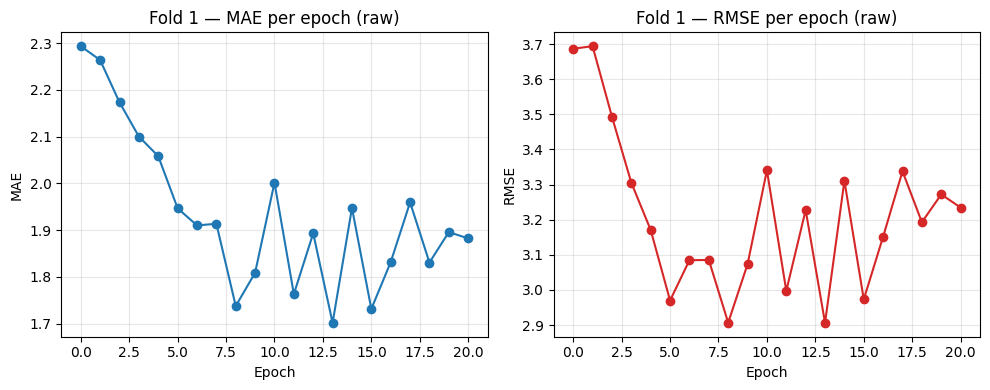

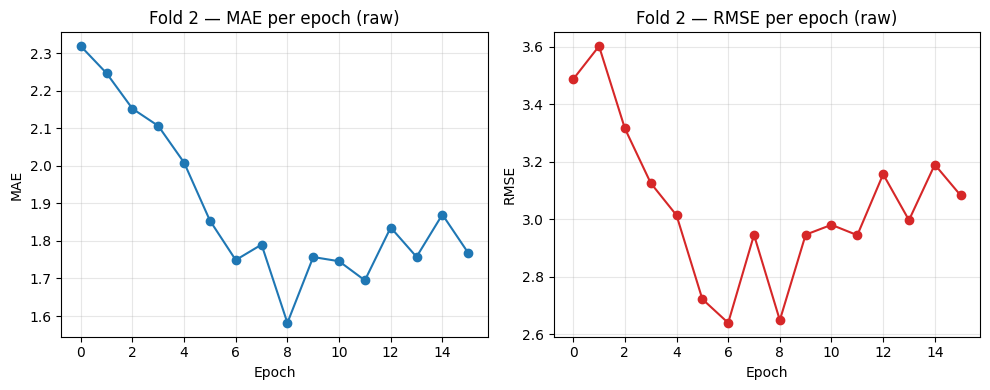

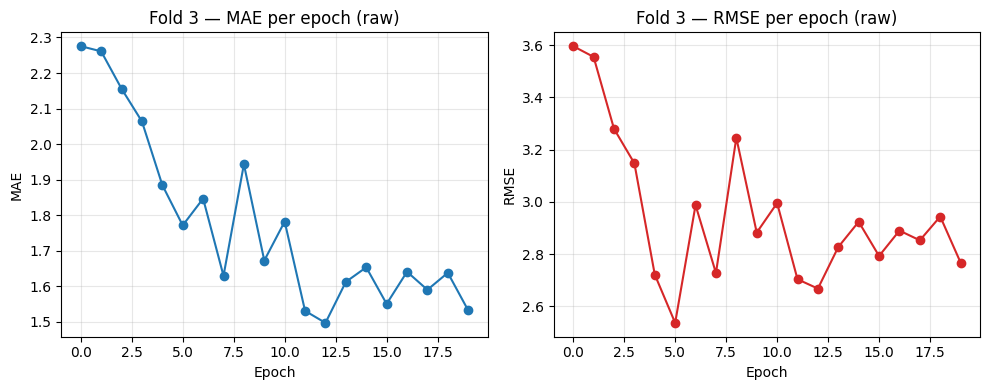

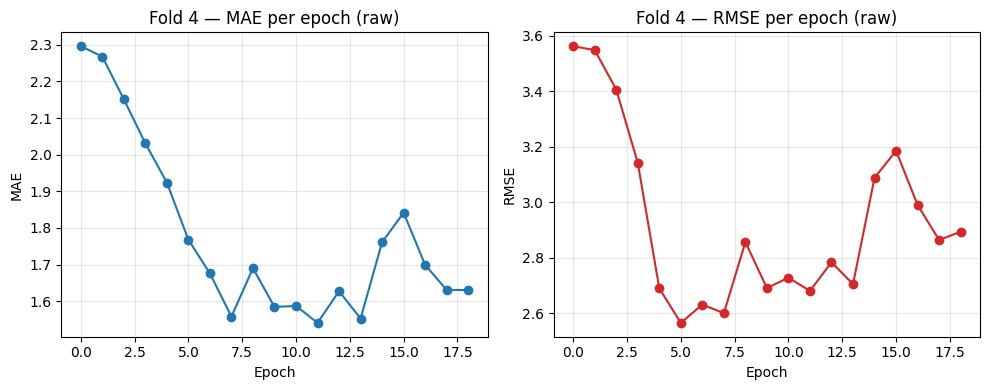

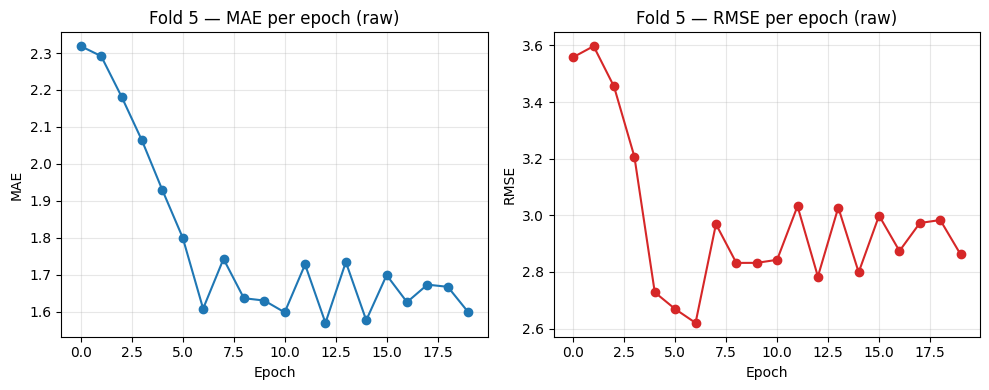

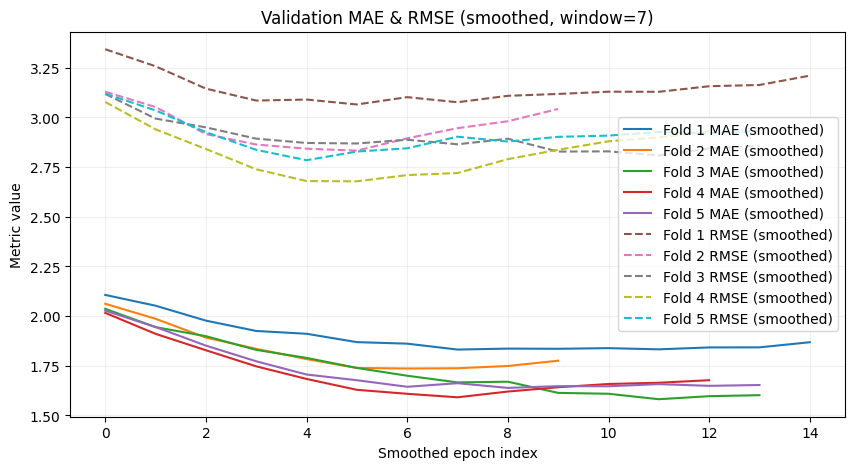

In [4]:
# -------------------------
# CHUNK 4b — Train Heteroscedastic MLP (v5) with MAE & RMSE metrics + per-epoch logging
# -------------------------
import numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import math, os

AUG_DIR = "/mnt/data/aug_v5"
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
SEED    = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

# Load arrays (unchanged)
X = np.load(f"{AUG_DIR}/X_train_final_v3.npy").astype(np.float32)
y = np.load(f"{AUG_DIR}/y_train_final_v3.npy").astype(np.float32)
metric_ids = np.load(f"{AUG_DIR}/metric_train_final_v3.npy").astype(int)

INPUT_DIM = X.shape[1]
print("Training set:", X.shape, y.shape)

# Dataset wrapper (unchanged)
class DS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): 
        return len(self.y)
    def __getitem__(self, i): 
        return self.X[i], self.y[i]

# Model (same)
class HeteroMLP(nn.Module):
    def __init__(self, inp):
        super().__init__()
        h1, h2, h3 = 1536, 768, 256
        self.net = nn.Sequential(
            nn.Linear(inp, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(0.13),
            nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(0.13),
            nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(0.13),
        )
        self.mu = nn.Linear(h3, 1)
        self.s  = nn.Linear(h3, 1)
        self.s.bias.data.fill_(-2.0)
    def forward(self, x):
        h = self.net(x)
        mu = self.mu(h).view(-1)
        log_var = self.s(h).view(-1)
        return mu, log_var

# Loss (same)
def hetero_loss(mu, log_var, y, alpha=0.45):
    log_var = torch.clamp(log_var, -12, 8)
    inv = torch.exp(-log_var)
    nll = 0.5 * (log_var + (y - mu)**2 * inv)
    return alpha * nll.mean() + (1 - alpha) * torch.abs(y - mu).mean()

# Training config (same)
FOLDS   = 5
BATCH   = 256
EPOCHS  = 35
LR      = 2e-4
WD      = 3e-6
PATIENCE = 7

gkf = GroupKFold(n_splits=FOLDS)
oof = np.zeros(len(X))

# histories across folds
fold_epoch_mae = []   # list of lists (per-fold epoch MAE)
fold_epoch_rmse = []  # list of lists (per-fold epoch RMSE)

# smoothing helper
def smooth(arr, window=7):
    if len(arr) < window:
        return np.array(arr)
    return np.convolve(arr, np.ones(window)/window, mode="valid")

# TRAIN
for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, metric_ids)):
    print(f"\n==============================")
    print(f" Fold {fold+1}/{FOLDS}")
    print(f"==============================")

    tr_ds = DS(X[tr_idx], y[tr_idx])
    va_ds = DS(X[va_idx], y[va_idx])

    tr_dl = DataLoader(tr_ds, batch_size=BATCH, shuffle=True)
    va_dl = DataLoader(va_ds, batch_size=BATCH, shuffle=False)

    model = HeteroMLP(INPUT_DIM).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

    best_mae = 999.0
    best_state = None
    patience = 0

    epoch_mae = []
    epoch_rmse = []

    for ep in range(EPOCHS):
        # Train
        model.train()
        for xb, yb in tr_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            mu, logv = model(xb)
            loss = hetero_loss(mu, logv, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.2)
            opt.step()

        # Validate
        model.eval()
        preds = []
        with torch.no_grad():
            for xb, _ in va_dl:
                xb = xb.to(DEVICE)
                mu, _ = model(xb)
                preds.append(mu.cpu().numpy())
        preds = np.concatenate(preds)
        mae = mean_absolute_error(y[va_idx], preds)
        rmse = math.sqrt(mean_squared_error(y[va_idx], preds))
        epoch_mae.append(mae)
        epoch_rmse.append(rmse)

        print(f"Epoch {ep+1:02d}  |  MAE: {mae:.5f}  |  RMSE: {rmse:.5f}")

        # Early stopping on MAE
        if mae < best_mae - 1e-4:
            best_mae = mae
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping.")
                break

    # save histories
    fold_epoch_mae.append(epoch_mae)
    fold_epoch_rmse.append(epoch_rmse)

    # Save fold state and OOF
    torch.save(best_state, f"{AUG_DIR}/hetero_v5_fold{fold+1}.pth")
    oof[va_idx] = preds
    print(f"Best fold MAE: {best_mae:.5f}")

# Final OOF metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
oof_mae = mean_absolute_error(y, oof)
oof_rmse = math.sqrt(mean_squared_error(y, oof))
oof_r2 = r2_score(y, oof)
print("\nFINAL OOF MAE:", oof_mae)
print("FINAL OOF RMSE:", oof_rmse)
print("FINAL OOF R2:", oof_r2)

# Save histories to disk for reporting
os.makedirs(f"{AUG_DIR}/reports", exist_ok=True)
np.save(f"{AUG_DIR}/reports/fold_epoch_mae.npy", np.array([np.array(h) for h in fold_epoch_mae], dtype=object))
np.save(f"{AUG_DIR}/reports/fold_epoch_rmse.npy", np.array([np.array(h) for h in fold_epoch_rmse], dtype=object))

# -----------------------
# Per-fold plots (raw)
# -----------------------
for i, (mae_hist, rmse_hist) in enumerate(zip(fold_epoch_mae, fold_epoch_rmse), start=1):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(mae_hist, marker='o')
    plt.title(f"Fold {i} — MAE per epoch (raw)")
    plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.grid(alpha=0.3)

    plt.subplot(1,2,2)
    plt.plot(rmse_hist, marker='o', color='C3')
    plt.title(f"Fold {i} — RMSE per epoch (raw)")
    plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.grid(alpha=0.3)

    plt.tight_layout(); plt.show()

# -----------------------
# Combined smoothed plot across folds
# -----------------------
plt.figure(figsize=(10,5))
for i, mae_hist in enumerate(fold_epoch_mae, start=1):
    s = smooth(mae_hist, window=7)
    plt.plot(s, label=f"Fold {i} MAE (smoothed)")
for i, rmse_hist in enumerate(fold_epoch_rmse, start=1):
    s = smooth(rmse_hist, window=7)
    plt.plot(s, linestyle='--', label=f"Fold {i} RMSE (smoothed)")
plt.title("Validation MAE & RMSE (smoothed, window=7)")
plt.xlabel("Smoothed epoch index"); plt.ylabel("Metric value")
plt.legend(); plt.grid(alpha=0.2); plt.show()


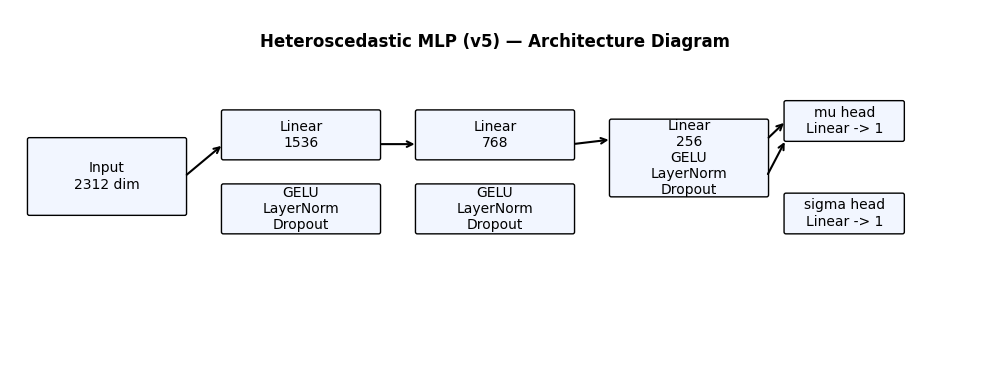

Saved model diagram to: /mnt/data/aug_v5/hetero_v5_architecture.png


In [5]:
# -------------------------
# Draw a simple model diagram (matplotlib) and save PNG
# -------------------------
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Arrow

def draw_block(ax, x, y, w, h, text, facecolor="#f2f6ff"):
    rect = FancyBboxPatch((x,y), w, h, boxstyle="round,pad=0.02", linewidth=1.0, facecolor=facecolor, edgecolor="k")
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha="center", va="center", fontsize=10)

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlim(0, 10); ax.set_ylim(0, 4)
ax.axis('off')

# Coordinates for blocks
draw_block(ax, 0.2, 1.8, 1.6, 0.8, f"Input\n{INPUT_DIM} dim")
draw_block(ax, 2.2, 2.4, 1.6, 0.5, "Linear\n1536")
draw_block(ax, 2.2, 1.6, 1.6, 0.5, "GELU\nLayerNorm\nDropout")
draw_block(ax, 4.2, 2.4, 1.6, 0.5, "Linear\n768")
draw_block(ax, 4.2, 1.6, 1.6, 0.5, "GELU\nLayerNorm\nDropout")
draw_block(ax, 6.2, 2.0, 1.6, 0.8, "Linear\n256\nGELU\nLayerNorm\nDropout")
draw_block(ax, 8.0, 2.6, 1.2, 0.4, "mu head\nLinear -> 1")
draw_block(ax, 8.0, 1.6, 1.2, 0.4, "sigma head\nLinear -> 1")

# arrows
def arrow(ax, x1,y1,x2,y2):
    ax.annotate("", xy=(x2,y2), xytext=(x1,y1),
                arrowprops=dict(arrowstyle="->", lw=1.5, color="k"))

arrow(ax, 1.8, 2.2, 2.2, 2.55)
arrow(ax, 3.8, 2.55, 4.2, 2.55)
arrow(ax, 5.8, 2.55, 6.2, 2.6)
arrow(ax, 7.8, 2.6, 8.0, 2.8)
arrow(ax, 7.8, 2.2, 8.0, 2.6)

# Title
ax.text(5, 3.6, "Heteroscedastic MLP (v5) — Architecture Diagram", ha="center", fontsize=12, weight="bold")

plt.tight_layout()
out_diagram = f"{AUG_DIR}/hetero_v5_architecture.png"
plt.savefig(out_diagram, dpi=150)
plt.show()
print("Saved model diagram to:", out_diagram)


### Inference Using Saved Heteroscedastic MLP Folds

In [20]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import os

AUG_DIR = "/mnt/data/aug_v5"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================
# Load Test Features
# =========================
X_test = np.load(f"{AUG_DIR}/X_test_final_v3.npy").astype(np.float32)
print("Test features:", X_test.shape)

# =========================
# Load model architecture
# (must match training)
# =========================
class HeteroMLP(nn.Module):
    def __init__(self, inp):
        super().__init__()
        h1, h2, h3 = 1536, 768, 256
        self.net = nn.Sequential(
            nn.Linear(inp, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(0.13),
            nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(0.13),
            nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(0.13),
        )
        self.mu = nn.Linear(h3, 1)
        self.s  = nn.Linear(h3, 1)
        self.s.bias.data.fill_(-2.0)

    def forward(self, x):
        h = self.net(x)
        mu = self.mu(h).view(-1)
        log_var = self.s(h).view(-1)
        return mu, log_var

INPUT_DIM = X_test.shape[1]
X_t = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

# =========================
# Load all folds
# =========================
fold_states = []
for i in range(1, 6):
    path = f"{AUG_DIR}/hetero_v5_fold{i}.pth"
    if os.path.exists(path):
        fold_states.append(torch.load(path, map_location="cpu"))
        print(f"Loaded fold {i} ✓")
    else:
        print(f"Missing fold file: {path}")

# =========================
# Run inference fold-wise
# =========================
preds_all = []
for i, state in enumerate(fold_states, start=1):
    model = HeteroMLP(INPUT_DIM).to(DEVICE)
    model.load_state_dict(state, strict=False)
    model.eval()

    with torch.no_grad():
        mu, _ = model(X_t)
        preds_all.append(mu.cpu().numpy())
    print(f"Inference fold {i} done.")

# Average across folds
preds = np.mean(np.vstack(preds_all), axis=0)

# Clip to valid range
preds = np.clip(preds, 0, 10)

print("\nPrediction stats:")
print("Min:", float(preds.min()))
print("Max:", float(preds.max()))
print("Mean:", float(preds.mean()))
print("Std:", float(preds.std()))


Test features: (3638, 2312)
Loaded fold 1 ✓
Loaded fold 2 ✓
Loaded fold 3 ✓
Loaded fold 4 ✓
Loaded fold 5 ✓
Inference fold 1 done.
Inference fold 2 done.
Inference fold 3 done.
Inference fold 4 done.
Inference fold 5 done.

Prediction stats:
Min: 1.3552383184432983
Max: 9.731876373291016
Mean: 6.308983325958252
Std: 2.9599788188934326


### Create Submission + Plot Prediction Distribution

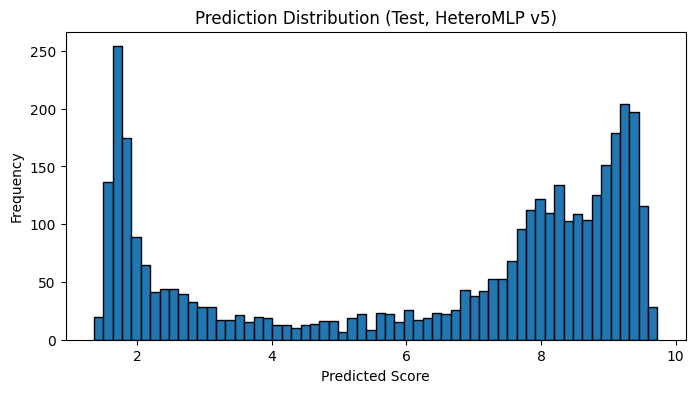

In [21]:
plt.figure(figsize=(8,4))
plt.hist(preds, bins=60, edgecolor="black")
plt.title("Prediction Distribution (Test, HeteroMLP v5)")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.show()


In [22]:
sub = pd.DataFrame({
    "id": np.arange(1, len(preds)+1),
    "score": preds
})

sub.to_csv("submission_v5_hetero.csv", index=False)
print("\nSaved submission_v5_hetero.csv")



Saved submission_v5_hetero.csv
